# NYC Property Sales Prediction with Google Trends

In [1]:
!pip install gtab==0.4

You should consider upgrading via the 'C:\Users\Aleksandra\miniconda3\envs\ada\python.exe -m pip install --upgrade pip' command.


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gtab
from sklearn.metrics import mean_absolute_error as mae
import plotly.graph_objects as go
%matplotlib inline

from statsmodels.tsa.ar_model import AutoReg
from datetime import *
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.ar_model import ar_select_order

## Loading and preprocessing the dataset

In [3]:
df = pd.read_csv("nyc-rolling-sales.csv", parse_dates=['SALE DATE'])
df.sample(5)

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
31100,5749,3,BROWNSVILLE,01 ONE FAMILY DWELLINGS,1,3569,38,,A5,2092 STRAUSS STREET,...,1,0,1,2000,1400,1899,1,A5,0,2016-09-01
51704,2306,4,BAYSIDE,10 COOPS - ELEVATOR APARTMENTS,2,5863,200,,D4,"209-25 18TH AVENUE, 6A",...,0,0,0,-,-,1960,2,D4,315000,2017-01-11
52774,3376,4,CAMBRIA HEIGHTS,01 ONE FAMILY DWELLINGS,1,11280,91,,A5,115-08 217TH STREET,...,1,0,1,2200,1554,1940,1,A5,355000,2017-08-21
64605,15207,4,JAMAICA,02 TWO FAMILY DWELLINGS,1,9833,32,,B3,175-50 88TH AVENUE,...,2,0,2,4000,1940,1920,1,B3,-,2016-12-13
84463,8329,5,WOODROW,01 ONE FAMILY DWELLINGS,1,7106,43,,A5,16 LORRAINE LOOP,...,1,0,1,1130,977,1991,1,A5,325000,2017-02-28


In [4]:
# delete unnecessary columns

# Dropping column as it is empty
del df['EASE-MENT']
# Dropping as it looks like an iterator
del df['Unnamed: 0']

In [5]:
# Checking for duplicated entries
sum(df.duplicated(df.columns))

765

In [6]:
# Delete the duplicates and check if it worked
df = df.drop_duplicates(df.columns, keep='last')
sum(df.duplicated(df.columns))

0

In [12]:
# Renaming BOROUGHS
df['BOROUGH'][df['BOROUGH'] == 1] = 'Manhattan'
df['BOROUGH'][df['BOROUGH'] == 2] = 'Bronx'
df['BOROUGH'][df['BOROUGH'] == 3] = 'Brooklyn'
df['BOROUGH'][df['BOROUGH'] == 4] = 'Queens'
df['BOROUGH'][df['BOROUGH'] == 5] = 'Staten Island'

In [13]:
# as there are rows where sale price is null, we should remove them from our dataset
df = df[df['SALE PRICE'].notnull()]

## Exploring the dataset

### Percentage of sold properties in NYC boroughs

In [14]:
df_vis = df.groupby('BOROUGH').count()
colors = ['wheat', 'plum', 'lightblue', 'coral', 'lavender']

fig = go.Figure(data=[go.Pie(labels=df_vis.index, values=df_vis['ADDRESS'], textinfo='label+percent', marker=dict(colors=colors),
                title='Percentage of sold properties in NYC boroughs')])
fig.show()


### Interactive plot showing number of sales 

In [15]:
# creating the copy of df dataset
df_new = df.copy()

# splitting the date to year and month to finally group it by month_year
df_new['year'] = pd.to_datetime(df_new['SALE DATE']).dt.year
df_new['month'] = pd.to_datetime(df_new['SALE DATE']).dt.month
df_new['month_year'] = df_new['month'].astype(str)+ '-' + df_new['year'].astype(str)
df_new['month_year'] = df_new['month_year'].apply(lambda x: datetime.strptime(x, '%m-%Y'))
df_new = df_new.loc[:, ['SALE PRICE', 'month_year', 'BOROUGH']].groupby(['month_year', 'BOROUGH']).aggregate('count')

# creating the dataframe for the interactive plot using unstack 
df_new = df_new.unstack('month_year')

# exporting the data for the interactive plot 
df_new.to_csv('out.csv')

https://app.flourish.studio/visualisation/4614082/

### Gross square feet in NYC boroughs

In [17]:
df_vis = df.copy()
# replacing missing values with 0 
df_vis['GROSS SQUARE FEET'] = df_vis['GROSS SQUARE FEET'].replace(' -  ', '0').astype(int)
# calculating the mean value, but ommiting values 0 we added in the previous step 
df_vis = df_vis[df_vis["GROSS SQUARE FEET"] != 0].groupby('BOROUGH')['GROSS SQUARE FEET'].mean()

fig = go.Figure(data=[go.Scatter(
    x = df_vis.index,
    y = df_vis,
    mode='markers',
    marker=dict(
        color=['yellow', 'purple', 'blue', 'orange', 'green'],
        size=[70, 55, 110, 30, 15],
        showscale=False,
        ))])

fig.show()

### Average sale price in NYC boroughs

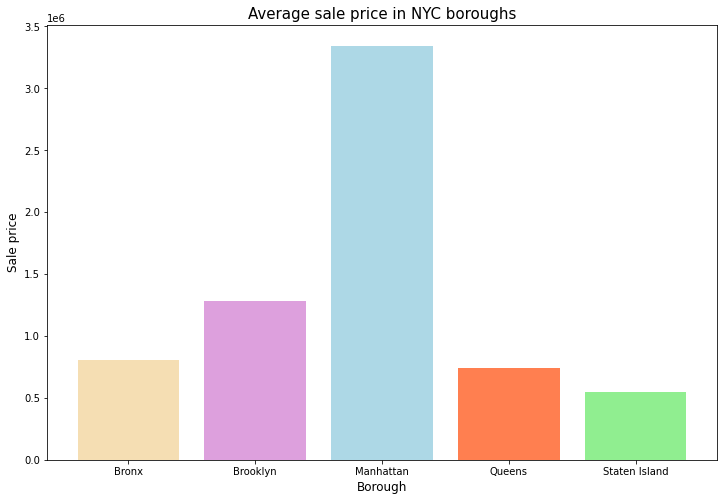

In [18]:
df_vi = df.copy()
# the same approach as in the previous plot
df_vi['SALE PRICE'] = df_vi['SALE PRICE'].replace(' -  ', '0').astype(float)
df_vi = df_vi[df_vi["SALE PRICE"] != 0].groupby('BOROUGH')['SALE PRICE'].mean()

plt.figure(figsize=(12,8))

x = df_vi.index
y = df_vi
plt.bar(x, y, color=['wheat', 'plum', 'lightblue', 'coral', 'lightgreen'])
plt.title('Average sale price in NYC boroughs', fontsize=15)
plt.xlabel('Borough', fontsize=12)
plt.ylabel('Sale price', fontsize=12)

plt.savefig("prices")
plt.show()

## Seasonal adjustment

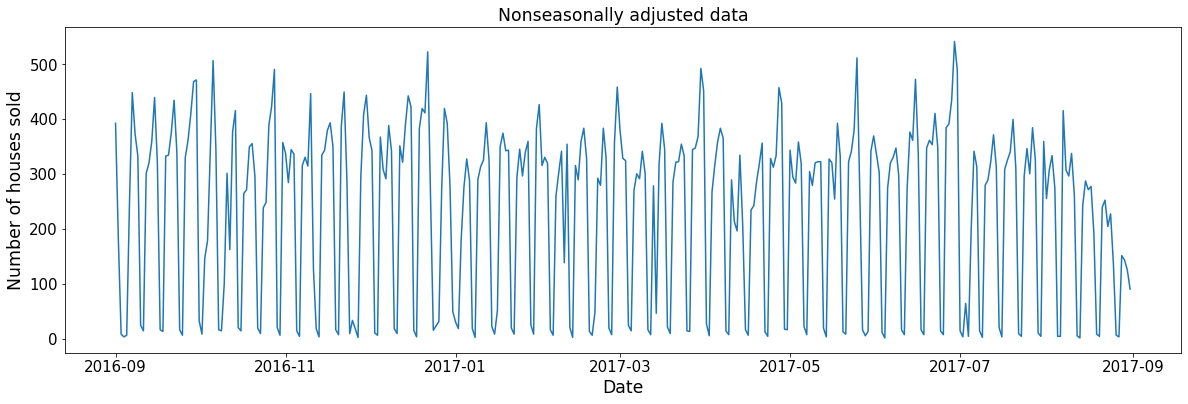

In [15]:
nsa_sales = df.loc[:, ['SALE PRICE', 'SALE DATE']].groupby('SALE DATE').aggregate('count')
plt.figure(figsize=(20, 6))
plt.plot(nsa_sales)
plt.title("Nonseasonally adjusted data", fontsize="xx-large")
plt.ylabel("Number of houses sold", fontsize="xx-large")
plt.xlabel("Date", fontsize="xx-large")
plt.tick_params(labelsize=15)
plt.savefig("nonseasonal.png")
plt.show()

During the weekends there were almost no transactions present and hence we can see so many ups and downs on the plot above. 

### Data grouped by weeks

Our first idea is to simply group the dates in weeks and aggregate the count of total properties sold.

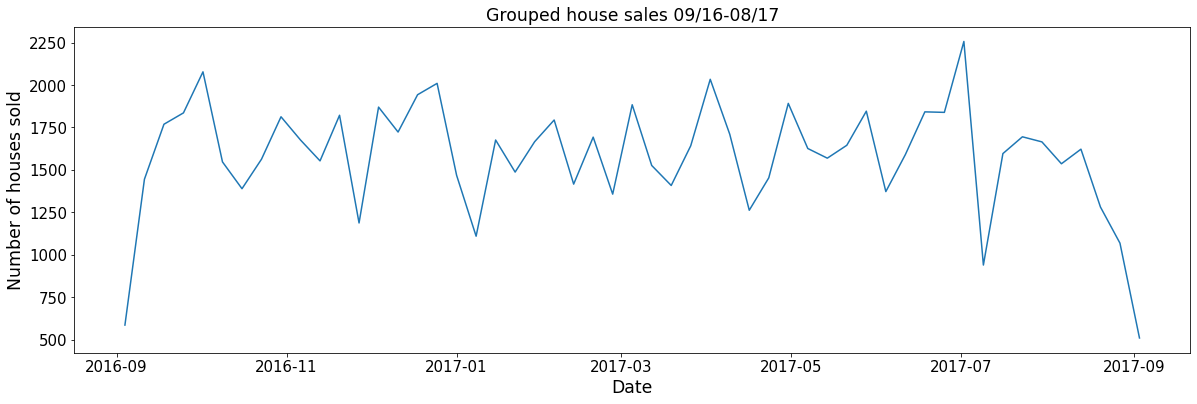

In [19]:
sa_sales = df.loc[:, ['SALE PRICE', 'SALE DATE']].groupby([pd.Grouper(key='SALE DATE', freq='W-SUN')]).aggregate('count')
plt.figure(figsize=(20, 6))
plt.plot(sa_sales)
plt.title("Grouped house sales 09/16-08/17", fontsize="xx-large")
plt.ylabel("Number of houses sold", fontsize="xx-large")
plt.xlabel("Date", fontsize="xx-large")
plt.tick_params(labelsize=15)
plt.savefig("seasonal_grouped.png")
plt.show()

We aren't satisfied with the results and as presented below we could still get a better overall trend from the data.

### Use STL to seasonally adjust the data

Just like in the Google Trends research paper we use STL for better seasonal adjustments. We want the data formatted to weeks starting by Sunday so we use the plot above and extract only the trends to our final data frame that will be used for further analysis (second plot from top).

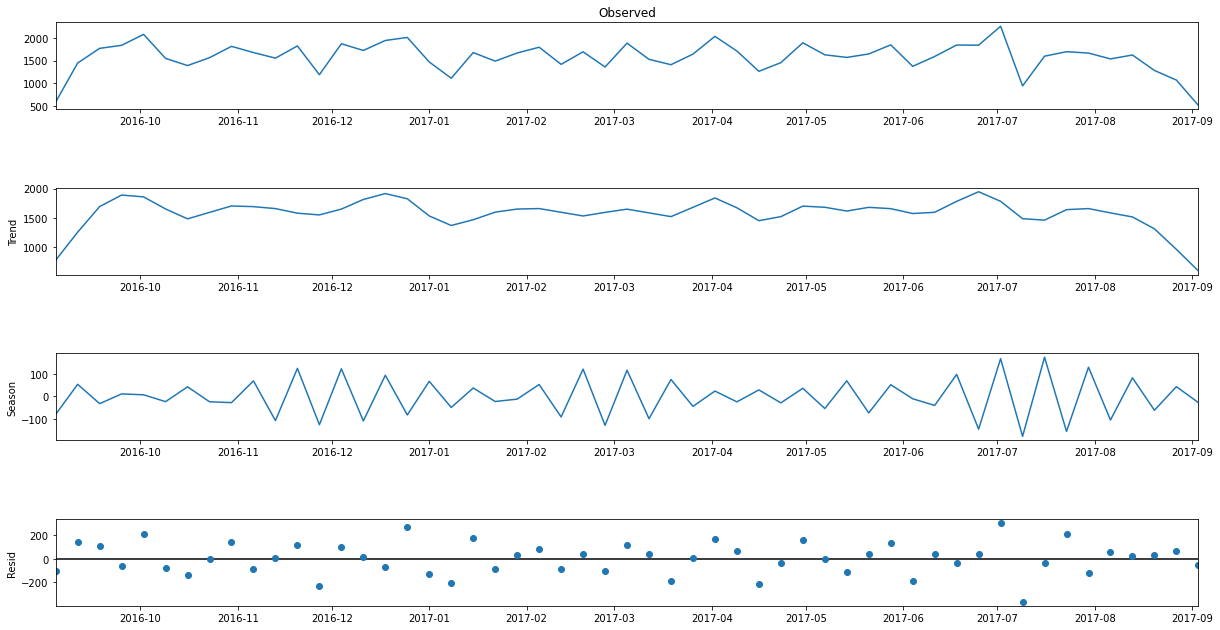

In [30]:
sa_stl_week = STL(
    df.loc[:, ['SALE PRICE', 'SALE DATE']].groupby([pd.Grouper(key='SALE DATE', freq='W-SUN')]).aggregate('count'), period=2).fit()
fig = sa_stl_week.plot()
fig.set_size_inches(20,10)

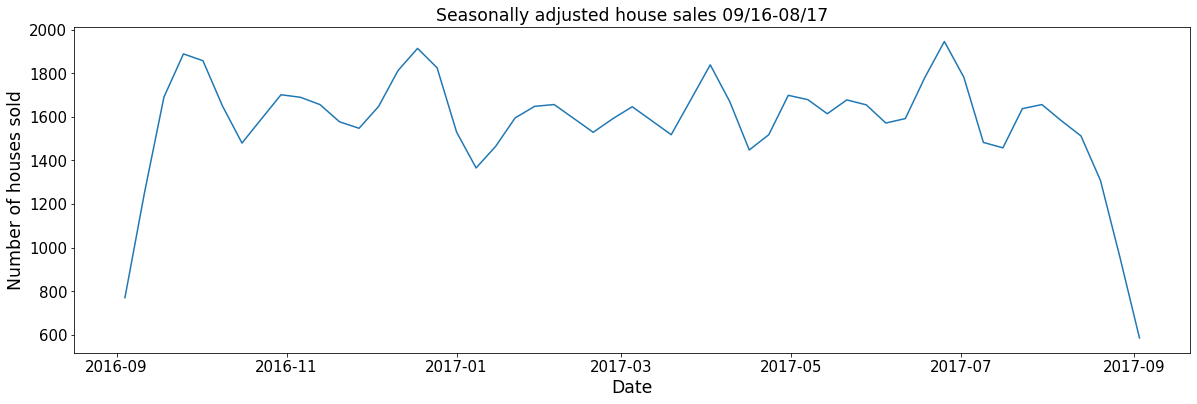

In [21]:
plt.figure(figsize=(20, 6))
plt.plot(sa_stl_week.trend.to_frame())
plt.title("Seasonally adjusted house sales 09/16-08/17", fontsize="xx-large")
plt.ylabel("Number of houses sold", fontsize="xx-large")
plt.xlabel("Date", fontsize="xx-large")
plt.tick_params(labelsize=15)
plt.savefig("seasonal_adjusted.png")
plt.show()

For almost all the trends we can see that there is a plunging trend at the end of the period. This isn’t due to some turning point but because we aggregate the weeks together and the last week doesn’t contain all 7 days, so the value is thus lower. That’s why further analysis and explaining the AR model last week will not be presented along with the trends.

## Loading the Google Trends data

In [6]:
# creating our own anchor bank for searching queries in NY with dates corresponding to these in our dataset 
my_path = "example_path"
t = gtab.GTAB(dir_path=my_path)
t.set_options(pytrends_config={"geo": "US-NY", "timeframe": "2016-09-05 2017-09-04"})

t.create_anchorbank() 

Directory already exists, loading data from it.
Using directory 'example_path'
Active anchorbank changed to: google_anchorbank_geo=_timeframe=2019-01-01 2020-08-01.tsv

Start AnchorBank init for region US-NY in timeframe 2016-09-05 2017-09-04...
GTAB with such parameters already exists! Load it with 'set_active_gtab(filename)' or rename/delete it to create another one with this name.


In [23]:
# setting our new anchor bank as default 
t = gtab.GTAB(dir_path="example_path")
t.set_active_gtab("google_anchorbank_geo=US-NY_timeframe=2016-09-05 2017-09-04.tsv")

Directory already exists, loading data from it.
Using directory 'example_path'
Active anchorbank changed to: google_anchorbank_geo=_timeframe=2019-01-01 2020-08-01.tsv

Active anchorbank changed to: google_anchorbank_geo=US-NY_timeframe=2016-09-05 2017-09-04.tsv



In [24]:
# choosing the queries for exploration in the later attempts
query_properties = t.new_query("property")
query_realestate = t.new_query("real estate")
query_realtor = t.new_query("realtor")
query_mortgage = t.new_query("mortgage")
query_houses = t.new_query("houses for sale")
query_mls = t.new_query("mls")
query_homes = t.new_query("homes for sale")

Using example_path\output\google_anchorbanks\google_anchorbank_geo=US-NY_timeframe=2016-09-05 2017-09-04.tsv
New query 'property'
New query calibrated!
Using example_path\output\google_anchorbanks\google_anchorbank_geo=US-NY_timeframe=2016-09-05 2017-09-04.tsv
New query 'real estate'
New query calibrated!
Using example_path\output\google_anchorbanks\google_anchorbank_geo=US-NY_timeframe=2016-09-05 2017-09-04.tsv
New query 'realtor'
New query calibrated!
Using example_path\output\google_anchorbanks\google_anchorbank_geo=US-NY_timeframe=2016-09-05 2017-09-04.tsv
New query 'mortgage'
New query calibrated!
Using example_path\output\google_anchorbanks\google_anchorbank_geo=US-NY_timeframe=2016-09-05 2017-09-04.tsv
New query 'houses for sale'
New query calibrated!
Using example_path\output\google_anchorbanks\google_anchorbank_geo=US-NY_timeframe=2016-09-05 2017-09-04.tsv
New query 'mls'
New query calibrated!
Using example_path\output\google_anchorbanks\google_anchorbank_geo=US-NY_timeframe=2

In [25]:
# saving the results in the new dataframe
queries_trends = pd.DataFrame()
queries_trends['property'] = query_properties['max_ratio']
queries_trends['real_estate'] = query_realestate['max_ratio']
queries_trends['realtor'] = query_realtor['max_ratio']
queries_trends['mortgage'] = query_mortgage['max_ratio']
queries_trends['houses'] = query_houses['max_ratio']
queries_trends['mls'] = query_mls['max_ratio']
queries_trends['homes'] = query_homes['max_ratio']

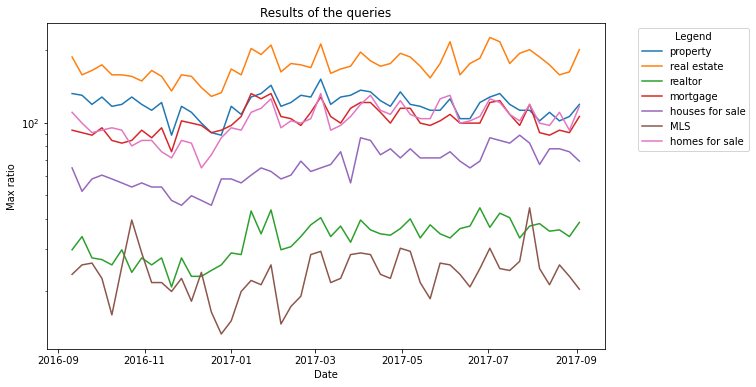

In [26]:
# plotting the results to see how the queries are connected with each other
plt.figure(figsize=(10, 6))
plt.plot(queries_trends['property'], label='property')
plt.plot(queries_trends['real_estate'], label='real estate')
plt.plot(queries_trends['realtor'], label='realtor')
plt.plot(queries_trends['mortgage'], label='mortgage')
plt.plot(queries_trends['houses'], label='houses for sale')
plt.plot(queries_trends['mls'], label='MLS')
plt.plot(queries_trends['homes'], label='homes for sale')
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Results of the queries')
plt.xlabel('Date')
plt.ylabel('Max ratio')
plt.yscale('log')
plt.show()

## Prepare dataset for prediction

In [32]:
sa_stl_week = sa_stl_week.trend.to_frame()
sa_stl_week['log_sales'] = np.log(sa_stl_week['trend'])
# ommiting the first date so the dataframe indices match to trends' queries
sa_stl_week = sa_stl_week[1:]

,trend,log_sales
SALE DATE,,
2016-09-11,1250.359060,7.131186
2016-09-18,1690.502602,7.432781
2016-09-25,1888.470490,7.543523
2016-10-02,1857.036942,7.526737
2016-10-09,1649.408780,7.408172
2016-10-16,1479.265778,7.299301
2016-10-23,1590.655507,7.371901
2016-10-30,1701.032825,7.438991
2016-11-06,1689.286369,7.432061


In [62]:
# using random seed to ensure consistency
np.random.seed(2)

## Prediction for base model

In [33]:
# computing the best lags for predictions
mods=ar_select_order(sa_stl_week['log_sales'], maxlag= 12, glob=True)
mods.ar_lags

C:\Users\Aleksandra\miniconda3\envs\ada\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Aleksandra\miniconda3\envs\ada\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 



array([1, 2, 3, 4, 5])

In [34]:
# set an autoregression of the base data
model_sa = AutoReg(sa_stl_week["log_sales"], lags=5)
base_res_sa = model_sa.fit()
print(base_res_sa.summary())

# predict results for base model
predictions_base = base_res_sa.predict(dynamic=False)

                            AutoReg Model Results                             
Dep. Variable:              log_sales   No. Observations:                   52
Model:                     AutoReg(5)   Log Likelihood                  66.292
Method:               Conditional MLE   S.D. of innovations              0.059
Date:                Fri, 18 Dec 2020   AIC                             -5.361
Time:                        21:03:11   BIC                             -5.085
Sample:                    10-16-2016   HQIC                            -5.257
                         - 09-03-2017                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -5.3705      1.768     -3.038      0.002      -8.835      -1.906
log_sales.L1     2.5052      0.146     17.129      0.000       2.219       2.792
log_sales.L2    -2.7100      0.319     -8.49

C:\Users\Aleksandra\miniconda3\envs\ada\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 



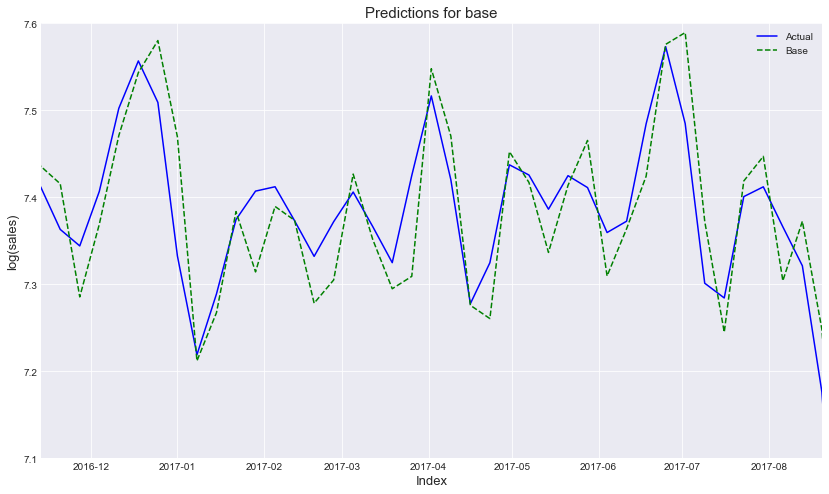

In [36]:
# Plotting predictions for base in comparison with actual trend

plt.figure(figsize=(14,8))
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.plot(sa_stl_week["log_sales"], label="Actual", color='b')
plt.plot(predictions_base, label="Base", color='green', linestyle='--')
plt.xlim((datetime(2016, 11, 13), datetime(2017, 8, 20)))
plt.ylim(7.1, 7.6)
plt.ylabel("log(sales)", fontsize=13)
plt.xlabel('Index', fontsize=13)
plt.title("Predictions for base", fontsize=15)
plt.legend()
plt.savefig("prediction_base.png")
plt.show()

## Prediction with Google Trends

### First attempt ###
Queries used: property, real estate

In [43]:
# choosing the best lags
mod = ar_select_order(sa_stl_week["log_sales"], maxlag=12, glob=True, exog=queries_trends[['property', 'real_estate']], old_names=False)
mod.ar_lags

C:\Users\Aleksandra\miniconda3\envs\ada\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

C:\Users\Aleksandra\miniconda3\envs\ada\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



array([1, 2, 3, 4, 5])

In [41]:
# model and predict

model_trends1 = AutoReg(sa_stl_week["log_sales"], lags=5, exog=queries_trends[['property', 'real_estate']], old_names=False)
base_res_trends1 = model_trends1.fit()
# print(base_res_trends1.summary())
predictions_trends1 = base_res_trends1.predict(dynamic=False)

C:\Users\Aleksandra\miniconda3\envs\ada\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



In [44]:
# computing the improvement
# Because of the lags, both predictions_base and predictions_trends have 5 NaN values. 
# To ensure the consistency, we calculated the MAEs from the 5th date.

mae_base = mae(sa_stl_week["log_sales"].iloc[5:], predictions_base[5:])
mae_trends1 = mae(sa_stl_week["log_sales"].iloc[5:], predictions_trends1[5:])
overall_improvement1 = (mae_base - mae_trends1)/mae_base
print('Overall improvement for 1st attempt {:.1%}'.format(overall_improvement1))

Overall improvement for 1st attempt 5.8%


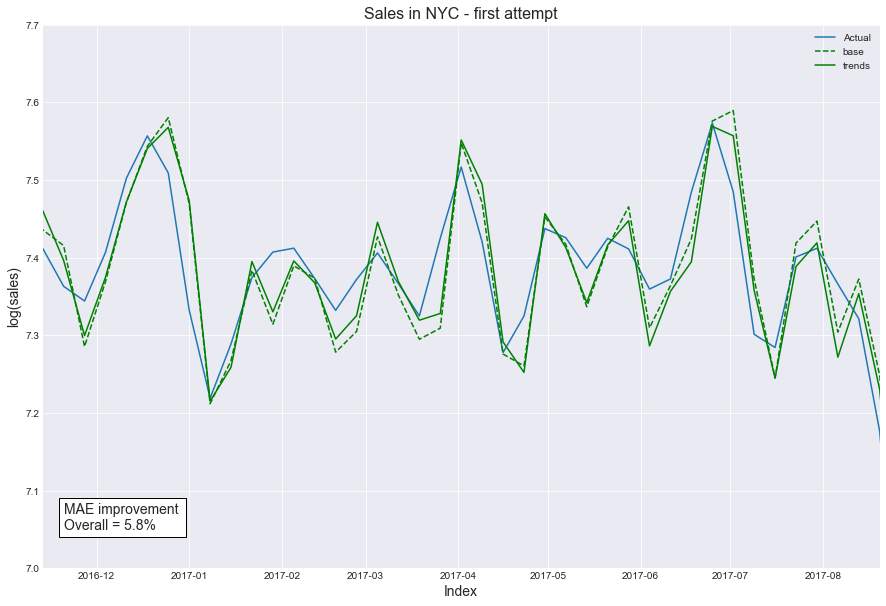

In [71]:
# Plotting the result for the first attempt

plt.figure(figsize=(15,10))
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.plot(sa_stl_week["log_sales"], label='Actual')
plt.plot(predictions_base, color='green', linestyle='--', label='base')
plt.plot(predictions_trends1, color='green', label='trends')
plt.xlim((datetime(2016, 11, 13), datetime(2017, 8, 20)))
plt.ylim(7.0, 7.7)

text = 'MAE improvement \nOverall = {:.1%}'.format(overall_improvement1)
props = dict(boxstyle='square', facecolor='white')
plt.text(sa_stl_week.index[10], 7.05, text, fontsize=14, bbox=props)

plt.title('Sales in NYC - first attempt', fontsize=16)
plt.ylabel('log(sales)', fontsize=14)
plt.xlabel('Index', fontsize=14)

plt.legend()
plt.savefig("prediciton_first.png")
plt.show()

### Second attempt ###
Queries used: property, real estate, mortgage, houses for sale

In [47]:
# choosing the best lags
mod = ar_select_order(sa_stl_week["log_sales"], maxlag=12, glob=True, exog=queries_trends[['property', 'real_estate', 'mortgage', 'houses']], old_names=False)
mod.ar_lags

C:\Users\Aleksandra\miniconda3\envs\ada\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

C:\Users\Aleksandra\miniconda3\envs\ada\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



array([1, 2, 3, 4, 5])

In [49]:
# model and predict 

model_trends2 = AutoReg(sa_stl_week["log_sales"], lags=5, exog=queries_trends[['property', 'real_estate', 'mortgage', 'houses']], old_names=False)
base_res_trends2 = model_trends2.fit()
# print(base_res_trends2.summary())
predictions_trends2 = base_res_trends2.predict(dynamic=False)

C:\Users\Aleksandra\miniconda3\envs\ada\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



In [50]:
# computing improvement

mae_trends2 = mae(sa_stl_week["log_sales"].iloc[5:], predictions_trends2[5:])
overall_improvement2 = (mae_base - mae_trends2)/mae_base
print('Overall improvement for 2nd attempt {:.1%}'.format(overall_improvement2))

Overall improvement for 2nd attempt 10.5%


### Third attempt ###
Queries used: property, real estate, mortgage, houses for sale, MLS

In [51]:
# choosing the best lags
mod = ar_select_order(sa_stl_week["log_sales"], maxlag=12, glob=True, exog=queries_trends[['property', 'real_estate', 'mortgage', 'houses', 'mls']], old_names=False)
mod.ar_lags

C:\Users\Aleksandra\miniconda3\envs\ada\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

C:\Users\Aleksandra\miniconda3\envs\ada\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



array([1, 2, 3, 4, 5])

In [52]:
# model and predict

model_trends3 = AutoReg(sa_stl_week["log_sales"], lags=5, exog=queries_trends[['property', 'real_estate', 'mortgage', 'houses', 'mls']], old_names=False)
base_res_trends3 = model_trends3.fit()
# print(base_res_trends3.summary())
predictions_trends3 = base_res_trends3.predict(dynamic=False)

C:\Users\Aleksandra\miniconda3\envs\ada\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



In [53]:
# computing improvement

mae_trends3 = mae(sa_stl_week["log_sales"].iloc[5:], predictions_trends3[5:])
overall_improvement3 = (mae_base - mae_trends3)/mae_base
print('Overall improvement for 3rd attempt {:.1%}'.format(overall_improvement3))

Overall improvement for 3rd attempt 10.4%


### Fourth attempt ###
Queries used: property, realtor, houses for sale, homes for sale, MLS

In [63]:
# choosing the best lags
mod = ar_select_order(sa_stl_week["log_sales"], maxlag=12, glob=True, exog=queries_trends[['property', 'realtor','houses','mls','homes']], old_names=False)
mod.ar_lags

C:\Users\Aleksandra\miniconda3\envs\ada\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

C:\Users\Aleksandra\miniconda3\envs\ada\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



array([1, 2, 3, 4, 5])

In [64]:
# model and predict 

model_trends4 = AutoReg(sa_stl_week["log_sales"], lags=5, exog=queries_trends[['property', 'realtor','houses','mls', 'homes']], old_names=False)
base_res_trends4 = model_trends4.fit()
# print(base_res_trends4.summary())
predictions_trends4 = base_res_trends4.predict(dynamic=False)

C:\Users\Aleksandra\miniconda3\envs\ada\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



In [65]:
# computing improvement

mae_base = mae(sa_stl_week["log_sales"].iloc[5:], predictions_base[5:])
mae_trends4 = mae(sa_stl_week["log_sales"].iloc[5:], predictions_trends[5:])
overall_improvement4 = (mae_base - mae_trends4)/mae_base
print('Overall improvement for 4th attempt {:.1%}'.format(overall_improvement4))

Overall improvement for 4th attempt 14.1%


### Fifth (final) attempt ###
Queries used: property, realtor, houses for sale, mortgage, homes for sale, MLS

In [66]:
# choosing the best lags
mod = ar_select_order(sa_stl_week["log_sales"], maxlag=12, glob=True, exog=queries_trends[['property', 'realtor', 'houses', 'mortgage', 'homes', 'mls']], old_names=False)
mod.ar_lags

C:\Users\Aleksandra\miniconda3\envs\ada\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

C:\Users\Aleksandra\miniconda3\envs\ada\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



array([1, 2, 3, 4, 5])

In [67]:
# model and predict

model_trends = AutoReg(sa_stl_week["log_sales"], lags=5, exog=queries_trends[['property', 'realtor', 'houses', 'mortgage', 'homes', 'mls']], old_names=False)
base_res_trends = model_trends.fit()
print(base_res_trends.summary())
predictions_trends = base_res_trends.predict(dynamic=False)

                            AutoReg Model Results                             
Dep. Variable:              log_sales   No. Observations:                   52
Model:                   AutoReg-X(5)   Log Likelihood                  72.130
Method:               Conditional MLE   S.D. of innovations              0.052
Date:                Fri, 18 Dec 2020   AIC                             -5.354
Time:                        21:36:29   BIC                             -4.842
Sample:                    10-16-2016   HQIC                            -5.161
                         - 09-03-2017                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -5.3312      1.734     -3.074      0.002      -8.730      -1.932
log_sales.L1     2.4967      0.133     18.721      0.000       2.235       2.758
log_sales.L2    -2.6376      0.291     -9.07

C:\Users\Aleksandra\miniconda3\envs\ada\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



In [68]:
# computing improvement

mae_trends = mae(sa_stl_week["log_sales"].iloc[5:], predictions_trends[5:])
overall_improvement = (mae_base - mae_trends)/mae_base
print('Overall improvement for the final attempt {:.1%}'.format(overall_improvement))

Overall improvement for the final attempt 14.2%


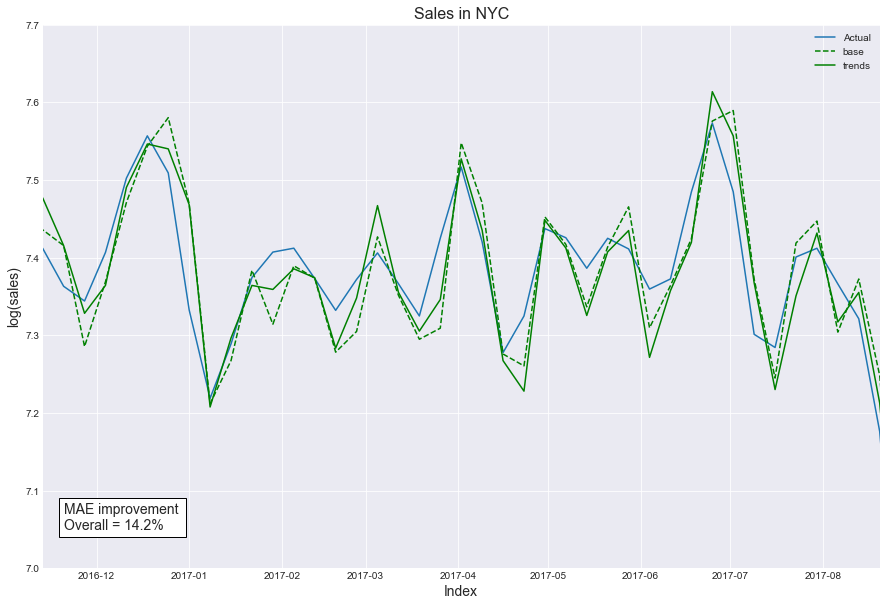

In [70]:
plt.figure(figsize=(15,10))
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.plot(sa_stl_week["log_sales"], label='Actual')
plt.plot(predictions_base, color='green', linestyle='--', label='base')
plt.plot(predictions_trends, color='green', label='trends')
plt.xlim((datetime(2016, 11, 13), datetime(2017, 8, 20)))
plt.ylim(7.0, 7.7)

text = 'MAE improvement \nOverall = {:.1%}'.format(overall_improvement)
props = dict(boxstyle='square', facecolor='white')
plt.text(sa_stl_week.index[10], 7.05, text, fontsize=14, bbox=props)

plt.title('Sales in NYC', fontsize=16)
plt.ylabel('log(sales)', fontsize=14)
plt.xlabel('Index', fontsize=14)

plt.legend()
plt.savefig("prediciton.png")
plt.show()

It's clearly seen that the MAE improves 14.2%, so we can conclude Google Trends data really has a positive influence on prediction. 